In [1]:
import os
import re
import gc
import cv2
import h5py
import torch
import string
import random
import numpy as np
import tensorflow as tf

from tqdm import tqdm
from nltk import tokenize
from sklearn import preprocessing

from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Rescaling, Resizing
from keras import Input
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.xception import Xception

from transformers import BertTokenizer, BertForMaskedLM, BertModel
from tensorflow.keras import Model

In [2]:
IMAGE_SIZE = (224, 224)
NUM_CHANNELS = 3

In [3]:
mvsa_single_path = '../input/mvsa-data/mvsa-single-4316.hdf5'
mvsa_multiple_path = '../input/mvsa-data/mvsa-multiple-16387.hdf5'

In [4]:
def read_hdf5(path):
    read_file = h5py.File(path, 'r')
    
    feature_names = list(read_file.keys())
    loaded_data = []
    
    for name in feature_names:
        dataset = read_file[name][:]
        if dataset.dtype == np.dtype('object'):
            dataset = np.array([x.decode('UTF-8') for x in dataset])            
        loaded_data.append((name, dataset))

    return loaded_data

In [5]:
def load_mvsa_data(path, multiple=False):
    data = read_hdf5(path)
    for x in data:
        if x[0] == 'texts':
            texts = x[1]
        if x[0] == 'images':
            images = x[1]
        if x[0] == 'multimodal-labels':
            labels = x[1]
        if x[0] == 'text-labels':
            text_labels = x[1]
        if x[0] == 'image-labels':
            image_labels = x[1]
            
    if multiple == True:
        images_path = os.path.join(os.path.split(path)[0], os.path.split(path)[1].split('.')[0] + '-images.npz')
#         npzfile = np.load(images_path)
#         images = npzfile['arr_0']
        images = loadz(images_path)
        
    return texts, images, labels, text_labels, image_labels

def loadz(path):
    data = np.load(path)['arr_0']
    return data

# Load raw data

In [6]:
mvsa_single_texts, mvsa_single_images, \
mvsa_single_multimodal_labels, mvsa_single_text_labels, \
mvsa_single_image_labels = load_mvsa_data(mvsa_single_path)
num_mvsa_single = len(mvsa_single_texts)

mvsa_multiple_texts, mvsa_multiple_images, \
mvsa_multiple_multimodal_labels, mvsa_multiple_text_labels, \
mvsa_multiple_image_labels = load_mvsa_data(mvsa_multiple_path, multiple=True)
num_mvsa_multiple = len(mvsa_multiple_texts)

-----Sample-----
Text label: neutral
Image label: positive
Multimodal label: positive
Text: Found another photo, not mine of my favorite food! The #sunset fades over the #desolate #winter #iowa #cornfield ##¡­ 
Image:


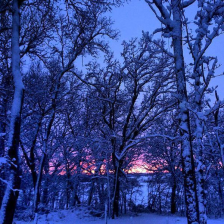

In [7]:
SAMPLE = random.choice(range(num_mvsa_single))
print('-----Sample-----')
print('Text label:', mvsa_single_text_labels[SAMPLE])
print('Image label:', mvsa_single_image_labels[SAMPLE])
print('Multimodal label:', mvsa_single_multimodal_labels[SAMPLE])
print('Text:', mvsa_single_texts[SAMPLE])
print('Image:')
tf.keras.utils.array_to_img(mvsa_single_images[SAMPLE])

# Xception

In [8]:
IMAGE_SIZE_XCEPTION = (299, 299) # required by Xception if no include_tops=False

In [9]:
xception = Xception(input_shape=(IMAGE_SIZE_XCEPTION[0], IMAGE_SIZE_XCEPTION[1], NUM_CHANNELS))
xception.trainable = False # Freeze pre-trained layers
xception_last = Model(inputs=xception.input, outputs=xception.layers[-2].output) # output of last hidden layer

2022-06-29 14:50:04.500102: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


91897856/91884032 [==============================] - 1s 0us/step


In [10]:
# Summary of VGG-19 is hidden
image_inputs = Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], NUM_CHANNELS))
resize_layer = Resizing(IMAGE_SIZE_XCEPTION[0], IMAGE_SIZE_XCEPTION[1]) (image_inputs)
rescale_layer = Rescaling(scale=1./255.) (resize_layer)  # Rescale inputs
outputs = xception_last (rescale_layer)
model_xception = Model(inputs=image_inputs, outputs=outputs)
model_xception.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resizing (Resizing)          (None, 299, 299, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 299, 299, 3)       0         
_________________________________________________________________
model (Functional)           (None, 2048)              20861480  
Total params: 20,861,480
Trainable params: 0
Non-trainable params: 20,861,480
_________________________________________________________________


In [11]:
print('MVSA-Single: Extracting Xception features of images')
mvsa_single_xception = model_xception.predict(mvsa_single_images, verbose=1)
print('Xception last hidden layer dimension:', mvsa_single_xception.shape[1])
print('MVSA-Single with Xception last hidden layer:', mvsa_single_xception.shape)

# save and load check
np.savez('./mvsa-single-xception', mvsa_single_xception)
x = loadz('./mvsa-single-xception.npz')
print((x == mvsa_single_xception).all())

MVSA-Single: Extracting Xception features of images


2022-06-29 14:50:08.847740: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


135/135 [==============================] - 616s 5s/step
Xception last hidden layer dimension: 2048
MVSA-Single with Xception last hidden layer: (4316, 2048)
True


In [12]:
print('MVSA-Multiple: Extracting Xception features of images')
mvsa_multiple_xception = model_xception.predict(mvsa_multiple_images, verbose=1)
print('Xception last hidden layer dimension:', mvsa_multiple_xception.shape[1])
print('MVSA-Multiple with Xception last hidden layer:', mvsa_multiple_xception.shape)

# save and load check
np.savez('./mvsa-multiple-xception', mvsa_multiple_xception)
x = loadz('./mvsa-multiple-xception.npz')
print((x == mvsa_multiple_xception).all())

MVSA-Multiple: Extracting Xception features of images
513/513 [==============================] - 2330s 5s/step
Xception last hidden layer dimension: 2048
MVSA-Multiple with Xception last hidden layer: (16387, 2048)
True
